# Welcome!

[General information here about the project and what this notebook does]

### Imports

In [ ]:
# !pip install neat-python
# !pip install pygame

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import neat

from snake_game import *

#Set the local directory
local_dir = os.getcwd()
neat_config_path = os.path.join(local_dir, Paths.NEAT_CONFIG_PATH)
config_path = os.path.join(local_dir, Paths.CONFIG_PATH)

# Load neat configuration into a NEAT object.
neat_config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                        neat.DefaultSpeciesSet, neat.DefaultStagnation,
                        neat_config_path)

## Basics Tutorial

We will first create an instance of the SnakeGame class and run the game for a few steps to see how it works. For now, we will use a simple game without any obstacles. The snake has information on its distance to the wall, distance to it's nearest body segment, and it's distance to the apple in all cardinal directions (up, down, left, right). The snake can also move in any of these directions.

In [2]:
SnakeV0 = SnakeGame(input_features= ['relative_wall', 'relative_body','relative_apple'],
                          input_frame_of_reference= 'NSEW', 
                          output_frame_of_reference= 'NSEW', 
                          use_obstacles= False,
                          n_runs = 5,
                          n_generations = 30,
                          time_interval= 200,
                          checkpoint_interval= 10)

#Update the NEAT configuration file with the input and output features of the SnakeV0 [This needs to be done every time the input features are changed]
print(SnakeV0.neat_params['input_output']['DefaultGenome'])
update_config('config-neat','DefaultGenome', SnakeV0.neat_params['input_output']['DefaultGenome'])

{'num_inputs': '12', 'num_outputs': '4'}


We will run the NEAT algorithm 5 times for 30 generations each. From these we obtain a list with the 'statistics' of each run, from which we can extract general information of the run using the [`StatisticsReporter`](https://neat-python.readthedocs.io/en/latest/_modules/statistics.html) module of neat-python.

In [3]:
#Run the NEAT algorithm on the SnakeV0
SnakeV0_stats = SnakeV0.run_NEAT_repeated(neat_config_path)

#Save results
np.save(local_dir + '/' + Paths.RESULTS_PATH + 'SnakeV0_stats', SnakeV0_stats)

# Get the best genome of all generations for all runs
Baseline_winners = [stats.best_genome() for stats in SnakeV0_stats]

# Get the best genome of all generations over all runs
best_run_idx = np.argmax([winner.fitness for winner in Baseline_winners])
print(f"Best run: {best_run_idx} with fitness:§ {Baseline_winners[best_run_idx].fitness}")

Running NEAT algorithm, run 0
Saving checkpoint to results//checkpoints/run0/population-9
Saving checkpoint to results//checkpoints/run0/population-19
Saving checkpoint to results//checkpoints/run0/population-29
Run 0 completed, best fitness: 7.5
Running NEAT algorithm, run 1
Saving checkpoint to results//checkpoints/run1/population-9
Saving checkpoint to results//checkpoints/run1/population-19
Saving checkpoint to results//checkpoints/run1/population-29
Run 1 completed, best fitness: 4.1
Running NEAT algorithm, run 2
Saving checkpoint to results//checkpoints/run2/population-9
Saving checkpoint to results//checkpoints/run2/population-19
Saving checkpoint to results//checkpoints/run2/population-29
Run 2 completed, best fitness: 6.5
Running NEAT algorithm, run 3
Saving checkpoint to results//checkpoints/run3/population-9
Saving checkpoint to results//checkpoints/run3/population-19
Saving checkpoint to results//checkpoints/run3/population-29
Run 3 completed, best fitness: 3.6
Running NEAT

### Visualize Results

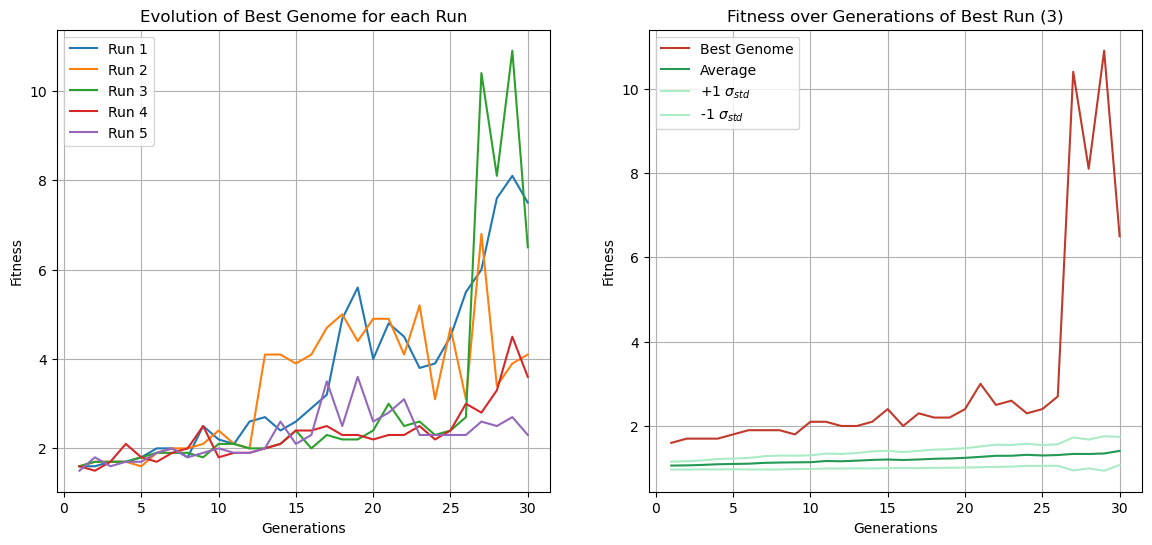

In [4]:
#Get statistics from the best run
generations = range(1, SnakeV0.N_GENERATIONS + 1)
winner_stats = SnakeV0_stats[best_run_idx]
best_fitnesses = [g.fitness for g in winner_stats.most_fit_genomes]
avg_fitnesses = np.array(winner_stats.get_fitness_mean())
stdev_fitnesses = np.array(winner_stats.get_fitness_stdev())

# Plot the best run statistics
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Get statistics from all runs
best_genomes = [[g for g in stats.most_fit_genomes] for stats in SnakeV0_stats]

# Plot the best genome of each run
for i, genome in enumerate(best_genomes):
    fitnesses = [g.fitness for g in genome]
    ax1.plot(generations, fitnesses, label=f"Run {i + 1}")

ax1.set_title("Evolution of Best Genome for each Run")
ax1.set_xlabel("Generations")
ax1.set_ylabel("Fitness")
ax1.grid()
ax1.legend(loc="best")

ax2.plot(generations, best_fitnesses, color='#c0392b', label="Best Genome")
ax2.plot(generations, avg_fitnesses, color='#229954', label="Average")
ax2.plot(generations, avg_fitnesses + stdev_fitnesses, color='#abebc6', label="+1 $\sigma_{std}$")
ax2.plot(generations, avg_fitnesses - stdev_fitnesses, color='#abebc6', label="-1 $\sigma_{std}$")

ax2.set_title(f"Fitness over Generations of Best Run ({best_run_idx + 1})")
ax2.set_xlabel("Generations")
ax2.set_ylabel("Fitness")
ax2.grid()
ax2.legend(loc="best")


plt.show()

### Simulate the best genome
It is also possible to visualize the best genome at any generation playing the game, which can be useful to understand how the snake is learning. Let's see how the best genome from the last run performs in the game.

In [5]:
generation_nr_1 = 15 
generation_nr_2 = -1 # -1 is the last generation

# Get the best genome at every generation
best_genomes = [g for g in SnakeV0_stats[best_run_idx].most_fit_genomes]

# genome_1 = best_genomes[generation_nr_1]
genome_2 = best_genomes[generation_nr_2]

#uncomment one to test either genome_1 or genome_2
# SnakeV0.test_winner(genome_1, neat_config_path)
# SnakeV0.test_winner(genome_2, neat_config_path)

# Investigation 1: Frame of Reference

Here we investigate the importance of the frame of reference our snake uses. One might have already noticed, that having outputs for each of the 4 directions is not very useful. This is because one output will always result in death (the snake running back in its own body). Instead, we can have 3 outputs: one for turning left, one for turning right and one for moving straight. We can set `output_frame_of_reference = 'SNAKE'` to use this frame of reference and compare performance.

In [6]:
SnakeV1 = SnakeGame(input_features= ['relative_wall', 'relative_body','relative_apple'],
                          input_frame_of_reference= 'NSEW', 
                          output_frame_of_reference= 'SNAKE', 
                          use_obstacles= False,
                          n_runs = 5,
                          n_generations = 30,
                          time_interval= 200,
                          checkpoint_interval= 10)

#Update the NEAT configuration file with the input and output features of the SnakeV0 [This needs to be done every time the input features are changed]
print(SnakeV1.neat_params['input_output']['DefaultGenome'])
update_config('config-neat','DefaultGenome', SnakeV1.neat_params['input_output']['DefaultGenome'])

#Run the NEAT algorithm on the SnakeV1
SnakeV1_stats = SnakeV1.run_NEAT_repeated(neat_config_path)
SnakeV1_winners = [stats.best_genome() for stats in SnakeV1_stats]

best_run_idx = np.argmax([winner.fitness for winner in SnakeV1_winners])
print(f"Best run: {best_run_idx} with fitness:§ {SnakeV1_winners[best_run_idx].fitness}")

#Save results
np.save(local_dir + '/' + Paths.RESULTS_PATH + 'SnakeV1_winners', SnakeV1_winners)
np.save(local_dir + '/' + Paths.RESULTS_PATH + 'SnakeV1_stats', SnakeV1_stats)

{'num_inputs': '12', 'num_outputs': '3'}
Running NEAT algorithm, run 0
Saving checkpoint to results//checkpoints/run0/population-9
Saving checkpoint to results//checkpoints/run0/population-19
Saving checkpoint to results//checkpoints/run0/population-29
Run 0 completed, best fitness: 2.0
Running NEAT algorithm, run 1
Saving checkpoint to results//checkpoints/run1/population-9
Saving checkpoint to results//checkpoints/run1/population-19
Saving checkpoint to results//checkpoints/run1/population-29
Run 1 completed, best fitness: 1.9
Running NEAT algorithm, run 2
Saving checkpoint to results//checkpoints/run2/population-9
Saving checkpoint to results//checkpoints/run2/population-19
Saving checkpoint to results//checkpoints/run2/population-29
Run 2 completed, best fitness: 1.7
Running NEAT algorithm, run 3
Saving checkpoint to results//checkpoints/run3/population-9
Saving checkpoint to results//checkpoints/run3/population-19
Saving checkpoint to results//checkpoints/run3/population-29
Run 3 

Note: The computation time now is a lot longer. This is because the snake cannot move back into itself, causing the average snake to live longer (although not necessarily doing anything useful like eating apples). You can check this yourself by setting 'time_to_eat_apple' to half the value, and see that the computation time is halved.

### Compare the two output frames of reference

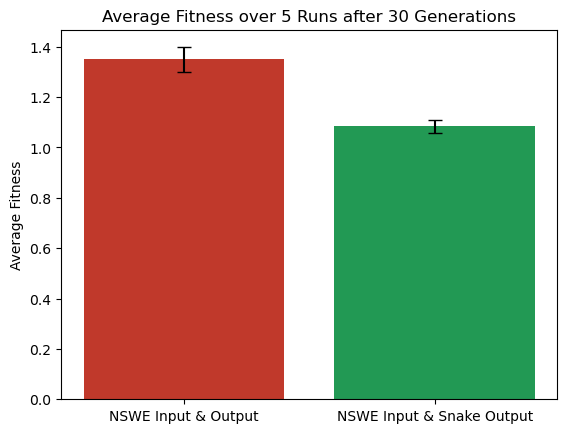

In [7]:
average_fitness_baseline = np.mean([np.array(stats.get_fitness_mean())[-1] for stats in SnakeV0_stats])
std_fitness_baseline = np.std([np.array(stats.get_fitness_mean())[-1] for stats in SnakeV0_stats])

# Calculate average fitness and standard deviation over all runs
average_fitness_V1= np.mean([np.array(stats.get_fitness_mean())[-1] for stats in SnakeV1_stats])
std_fitness_V1 = np.std([np.array(stats.get_fitness_mean())[-1] for stats in SnakeV1_stats])

# Data to plot
fitness_means = [average_fitness_baseline, average_fitness_V1]
fitness_stds = [std_fitness_baseline, std_fitness_V1]
labels = ['NSWE Input & Output', 'NSWE Input & Snake Output']

# Creating the bar plot
fig, ax = plt.subplots()
ax.bar(labels, fitness_means, yerr=fitness_stds, capsize=5, color=['#c0392b', '#229954'])
ax.set_ylabel('Average Fitness')
ax.set_title(f'Average Fitness over {SnakeV0.N_RUNS} Runs after {SnakeV0.N_GENERATIONS} Generations')

# Show the plot
plt.savefig(local_dir + '/' + Paths.RESULTS_PATH + '/fitness_comparison.png')
plt.show()

We could say that that result is not that great. Although it might seem we made the network's job easier by reducing the number of outputs and not being able to run in itself, we gave it a much harder task: learn a coordinate transformation from the cardinal directions to the new frame of reference. This is a much harder task than simply learning to avoid running into itself.

To fix this, we can define the inputs of the network in the new frame of reference. This way, the network will not have to learn the transformation. We can set `input_frame_of_reference = 'SNAKE'` to use this frame of reference and compare performance.

In [8]:
SnakeV2 = SnakeGame(input_features= ['relative_wall', 'relative_body','relative_apple'],
                          input_frame_of_reference= 'SNAKE', 
                          output_frame_of_reference= 'SNAKE', 
                          use_obstacles= False,
                          n_runs = 5,
                          n_generations = 30,
                          time_interval= 200,
                          checkpoint_interval= 10)

#Update the NEAT configuration file with the input and output features of the SnakeV0 [This needs to be done every time the input features are changed]
print(SnakeV2.neat_params['input_output']['DefaultGenome'])
update_config('config-neat','DefaultGenome', SnakeV2.neat_params['input_output']['DefaultGenome'])

#Run the NEAT algorithm on the SnakeV2
SnakeV2_stats= SnakeV2.run_NEAT_repeated(neat_config_path)
SnakeV2_winners = [stats.best_genome() for stats in SnakeV2_stats]
best_run_idx = np.argmax([winner.fitness for winner in SnakeV2_winners])
print(f"Best run: {best_run_idx} with fitness:§ {SnakeV2_winners[best_run_idx].fitness}")

#Save results
np.save(local_dir + '/' + Paths.RESULTS_PATH + 'SnakeV2_winners', SnakeV2_winners)
np.save(local_dir + '/' + Paths.RESULTS_PATH + 'SnakeV2_stats', SnakeV2_stats)

{'num_inputs': '9', 'num_outputs': '3'}
Running NEAT algorithm, run 0
Saving checkpoint to results//checkpoints/run0/population-9
Saving checkpoint to results//checkpoints/run0/population-19
Saving checkpoint to results//checkpoints/run0/population-29
Run 0 completed, best fitness: 25.4
Running NEAT algorithm, run 1
Saving checkpoint to results//checkpoints/run1/population-9
Saving checkpoint to results//checkpoints/run1/population-19
Saving checkpoint to results//checkpoints/run1/population-29
Run 1 completed, best fitness: 25.5
Running NEAT algorithm, run 2
Saving checkpoint to results//checkpoints/run2/population-9
Saving checkpoint to results//checkpoints/run2/population-19
Saving checkpoint to results//checkpoints/run2/population-29
Run 2 completed, best fitness: 26.6
Running NEAT algorithm, run 3
Saving checkpoint to results//checkpoints/run3/population-9
Saving checkpoint to results//checkpoints/run3/population-19
Saving checkpoint to results//checkpoints/run3/population-29
Run 

### Add new result to the plot

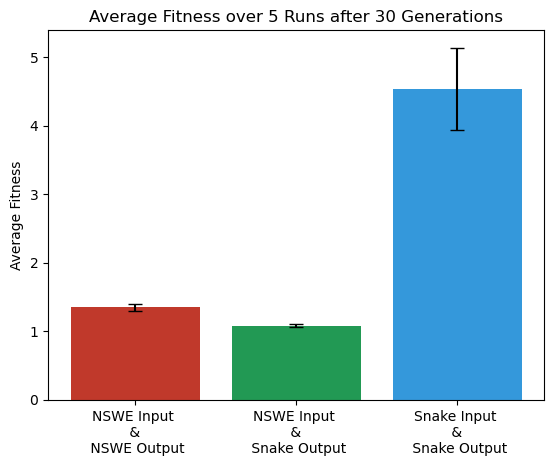

In [9]:
# Calculate average fitness and standard deviation over all runs
average_fitness_V2= np.mean([np.array(stats.get_fitness_mean())[-1] for stats in SnakeV2_stats])
std_fitness_V2 = np.std([np.array(stats.get_fitness_mean())[-1] for stats in SnakeV2_stats])

# Data to plot
fitness_means = [average_fitness_baseline, average_fitness_V1, average_fitness_V2]
fitness_stds = [std_fitness_baseline, std_fitness_V1, std_fitness_V2]
labels = ['NSWE Input \n & \n NSWE Output', 'NSWE Input \n & \n Snake Output', 'Snake Input \n & \n Snake Output']

# Creating the bar plot
fig, ax = plt.subplots()
ax.bar(labels, fitness_means, yerr=fitness_stds, capsize=5, color=['#c0392b', '#229954', '#3498db'])
ax.set_ylabel('Average Fitness')
ax.set_title(f'Average Fitness over {SnakeV0.N_RUNS} Runs after {SnakeV0.N_GENERATIONS} Generations')

# Show the plot
plt.savefig(local_dir + '/' + Paths.RESULTS_PATH + '/fitness_comparison.png')
plt.show()

### Check how the little fellow is doing

In [10]:
generation_nr_1 = 15 
generation_nr_2 = -1 # -1 is the last generation

# Get the best genome at every generation
best_genomes = [g for g in SnakeV2_stats[best_run_idx].most_fit_genomes]

genome_1 = best_genomes[generation_nr_1]
genome_2 = best_genomes[generation_nr_2]

#uncomment one to test either genome_1 or genome_2
# SnakeV0.test_winner(genome_1, neat_config_path)
# SnakeV0.test_winner(genome_2, neat_config_path)

### Reversed Situation

For sake of curiosity, we can also test the performance of the network in the reversed situation, where the inputs are in the new frame of reference and the outputs are in the old frame of reference.

{'num_inputs': '9', 'num_outputs': '4'}
Running NEAT algorithm, run 0
Saving checkpoint to results//checkpoints/run0/population-9
Saving checkpoint to results//checkpoints/run0/population-19
Saving checkpoint to results//checkpoints/run0/population-29
Run 0 completed, best fitness: 1.4
Running NEAT algorithm, run 1
Saving checkpoint to results//checkpoints/run1/population-9
Saving checkpoint to results//checkpoints/run1/population-19
Saving checkpoint to results//checkpoints/run1/population-29
Run 1 completed, best fitness: 1.4
Running NEAT algorithm, run 2
Saving checkpoint to results//checkpoints/run2/population-9
Saving checkpoint to results//checkpoints/run2/population-19
Saving checkpoint to results//checkpoints/run2/population-29
Run 2 completed, best fitness: 1.5
Running NEAT algorithm, run 3
Saving checkpoint to results//checkpoints/run3/population-9
Saving checkpoint to results//checkpoints/run3/population-19
Saving checkpoint to results//checkpoints/run3/population-29
Run 3 c

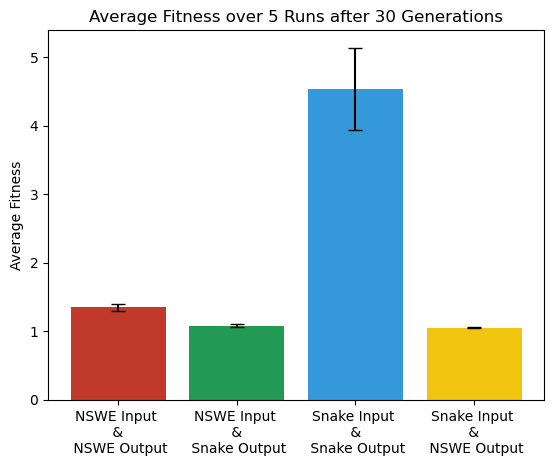

In [12]:
SnakeV3 = SnakeGame(input_features= ['relative_wall', 'relative_body','relative_apple'],
                          input_frame_of_reference= 'SNAKE', 
                          output_frame_of_reference= 'NSEW', 
                          use_obstacles= False,
                          n_runs = 5,
                          n_generations = 30,
                          time_interval= 200,
                          checkpoint_interval= 10)

#Update the NEAT configuration file with the input and output features of the SnakeV0 [This needs to be done every time the input features are changed]
print(SnakeV3.neat_params['input_output']['DefaultGenome'])
update_config('config-neat','DefaultGenome', SnakeV3.neat_params['input_output']['DefaultGenome'])

#Run the NEAT algorithm on the SnakeV3
SnakeV3_stats = SnakeV3.run_NEAT_repeated(neat_config_path)
SnakeV3_winners = [stats.best_genome() for stats in SnakeV3_stats]
best_run_idx = np.argmax([winner.fitness for winner in SnakeV3_winners])
print(f"Best run: {best_run_idx} with fitness:§ {SnakeV3_winners[best_run_idx].fitness}")

#Save results
np.save(local_dir + '/' + Paths.RESULTS_PATH + 'SnakeV3_winners', SnakeV3_winners)
np.save(local_dir + '/' + Paths.RESULTS_PATH + 'SnakeV3_stats', SnakeV3_stats)

# Calculate average fitness and standard deviation over all runs
average_fitness_V3= np.mean([np.array(stats.get_fitness_mean())[-1] for stats in SnakeV3_stats])
std_fitness_V3 = np.std([np.array(stats.get_fitness_mean())[-1] for stats in SnakeV3_stats])

# Data to plot
fitness_means = [average_fitness_baseline, average_fitness_V1, average_fitness_V2, average_fitness_V3]
fitness_stds = [std_fitness_baseline, std_fitness_V1, std_fitness_V2, std_fitness_V3]
labels = ['NSWE Input \n & \n NSWE Output', 'NSWE Input \n & \n Snake Output', 'Snake Input \n & \n Snake Output', 'Snake Input \n & \n NSWE Output']

# Creating the bar plot
fig, ax = plt.subplots()
ax.bar(labels, fitness_means, yerr=fitness_stds, capsize=5, color=['#c0392b', '#229954', '#3498db', '#f1c40f'])
ax.set_ylabel('Average Fitness')
ax.set_title(f'Average Fitness over {SnakeV0.N_RUNS} Runs after {SnakeV0.N_GENERATIONS} Generations')

# Show the plot
plt.savefig(local_dir + '/' + Paths.RESULTS_PATH + '/fitness_comparison.png')
plt.show()

### Dummy Inputs and Outputs

We can see this works much better. However, the snake does learn faster, but it does not learn better [You can check this yourself by setting the amount of generations higher, try ~200 generations for SnakeV0 and 200 for SnakeV1, if you have the time for such shenanigans].

 There is now an open question: why does the network perform better when the inputs are in the new frame of reference? Is it simply because the network cannot run into itself anymore, or is it because the network is smaller, and thus easier to evolve? We can test this by using the new frame of reference but by adding a set of dummy inputs and outputs, to have the same network size as in the baseline model. 

In [15]:
SnakeV4 = SnakeGame(input_features= ['relative_wall', 'relative_body','relative_apple'],
                          input_frame_of_reference= 'SNAKE', 
                          output_frame_of_reference= 'SNAKE', 
                          use_obstacles= False,
                          n_runs = 5,
                          min_time_to_eat_apple= 50,
                          n_generations = 30,
                          time_interval= 200,
                          checkpoint_interval= 1,
                          use_dummy_inputs= True)

#Update the NEAT configuration file with the input and output features of the SnakeV0 [This needs to be done every time the input features are changed]
print(SnakeV4.neat_params['input_output']['DefaultGenome'])
update_config('config-neat','DefaultGenome', SnakeV4.neat_params['input_output']['DefaultGenome'])

#Run the NEAT algorithm
SnakeV4_stats = SnakeV4.run_NEAT_repeated(neat_config_path)
SnakeV4_winners = [stats.best_genome() for stats in SnakeV4_stats]
best_run_idx = np.argmax([winner.fitness for winner in SnakeV4_winners])
print(f"Best run: {best_run_idx} with fitness:§ {SnakeV4_winners[best_run_idx].fitness}")

#Save results
np.save(local_dir + '/' + Paths.RESULTS_PATH + 'SnakeV4_winners', SnakeV4_winners)
np.save(local_dir + '/' + Paths.RESULTS_PATH + 'SnakeV4_stats', SnakeV4_stats)

{'num_inputs': '12', 'num_outputs': '4'}
Running NEAT algorithm, run 0
Saving checkpoint to results//checkpoints/run0/population-0
Saving checkpoint to results//checkpoints/run0/population-1
Saving checkpoint to results//checkpoints/run0/population-2
Saving checkpoint to results//checkpoints/run0/population-3
Saving checkpoint to results//checkpoints/run0/population-4
Saving checkpoint to results//checkpoints/run0/population-5
Saving checkpoint to results//checkpoints/run0/population-6
Saving checkpoint to results//checkpoints/run0/population-7
Saving checkpoint to results//checkpoints/run0/population-8
Saving checkpoint to results//checkpoints/run0/population-9
Saving checkpoint to results//checkpoints/run0/population-10
Saving checkpoint to results//checkpoints/run0/population-11
Saving checkpoint to results//checkpoints/run0/population-12
Saving checkpoint to results//checkpoints/run0/population-13
Saving checkpoint to results//checkpoints/run0/population-14
Saving checkpoint to res

In [16]:
generation_nr_1 = 15 
generation_nr_2 = -1 # -1 is the last generation

# Get the best genome at every generation
best_genomes = [g for g in SnakeV4_stats[best_run_idx].most_fit_genomes]

genome_1 = best_genomes[generation_nr_1]
genome_2 = best_genomes[generation_nr_2]

#uncomment one to test either genome_1 or genome_2
# SnakeV4.test_winner(genome_1, neat_config_path)
# SnakeV4.test_winner(genome_2, neat_config_path)

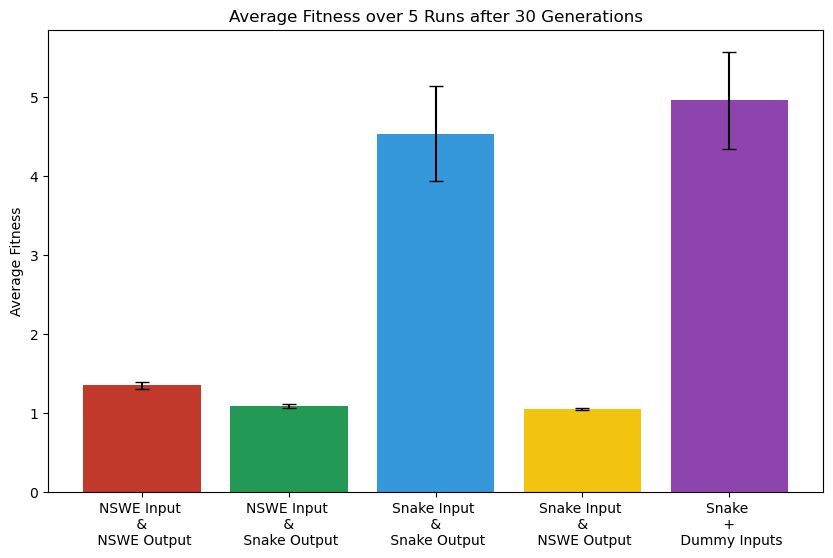

In [19]:
# Calculate average fitness and standard deviation over all runs
average_fitness_V4= np.mean([np.array(stats.get_fitness_mean())[-1] for stats in SnakeV4_stats])
std_fitness_V4 = np.std([np.array(stats.get_fitness_mean())[-1] for stats in SnakeV4_stats])

# Data to plot
fitness_means = [average_fitness_baseline, average_fitness_V1, average_fitness_V2, average_fitness_V3, average_fitness_V4]
fitness_stds = [std_fitness_baseline, std_fitness_V1, std_fitness_V2, std_fitness_V3, std_fitness_V4]
labels = ['NSWE Input \n & \n NSWE Output', 'NSWE Input \n & \n Snake Output', 'Snake Input \n & \n Snake Output', 'Snake Input \n & \n NSWE Output', 'Snake \n + \n Dummy Inputs']

# Creating the bar plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(labels, fitness_means, yerr=fitness_stds, capsize=5, color=['#c0392b', '#229954', '#3498db', '#f1c40f', '#8e44ad'])
ax.set_ylabel('Average Fitness')
ax.set_title(f'Average Fitness over {SnakeV0.N_RUNS} Runs after {SnakeV0.N_GENERATIONS} Generations')

# Show the plot
plt.savefig(local_dir + '/' + Paths.RESULTS_PATH + '/fitness_comparison.png')
plt.show()

# Investigation 2: Binary Inputs

In [20]:
SnakeV5 = SnakeGame(input_features= ['binary_wall', 'binary_body','binary_apple'],
                          input_frame_of_reference= 'SNAKE', 
                          output_frame_of_reference= 'SNAKE', 
                          use_obstacles= False,
                          n_runs = 5,
                          n_generations = 30,
                          time_interval= 200,
                          checkpoint_interval= 10)

#Update the NEAT configuration file with the input and output features of the SnakeV0 [This needs to be done every time the input features are changed]
print(SnakeV5.neat_params['input_output']['DefaultGenome'])
update_config('config-neat','DefaultGenome', SnakeV5.neat_params['input_output']['DefaultGenome'])


#Run the NEAT algorithm
SnakeV5_stats = SnakeV5.run_NEAT_repeated(neat_config_path)
SnakeV5_winners = [stats.best_genome() for stats in SnakeV5_stats]
best_run_idx = np.argmax([winner.fitness for winner in SnakeV5_winners])
print(f"Best run: {best_run_idx} with fitness:§ {SnakeV5_winners[best_run_idx].fitness}")

#Save results
np.save(local_dir + '/' + Paths.RESULTS_PATH + 'SnakeV5_winners', SnakeV5_winners)
np.save(local_dir + '/' + Paths.RESULTS_PATH + 'SnakeV5_stats', SnakeV5_stats)

{'num_inputs': '9', 'num_outputs': '3'}
Running NEAT algorithm, run 0
Saving checkpoint to results//checkpoints/run0/population-9
Saving checkpoint to results//checkpoints/run0/population-19
Saving checkpoint to results//checkpoints/run0/population-29
Run 0 completed, best fitness: 26.2
Running NEAT algorithm, run 1
Saving checkpoint to results//checkpoints/run1/population-9
Saving checkpoint to results//checkpoints/run1/population-19
Saving checkpoint to results//checkpoints/run1/population-29
Run 1 completed, best fitness: 26.4
Running NEAT algorithm, run 2
Saving checkpoint to results//checkpoints/run2/population-9
Saving checkpoint to results//checkpoints/run2/population-19
Saving checkpoint to results//checkpoints/run2/population-29
Run 2 completed, best fitness: 26.0
Running NEAT algorithm, run 3
Saving checkpoint to results//checkpoints/run3/population-9
Saving checkpoint to results//checkpoints/run3/population-19
Saving checkpoint to results//checkpoints/run3/population-29
Run 

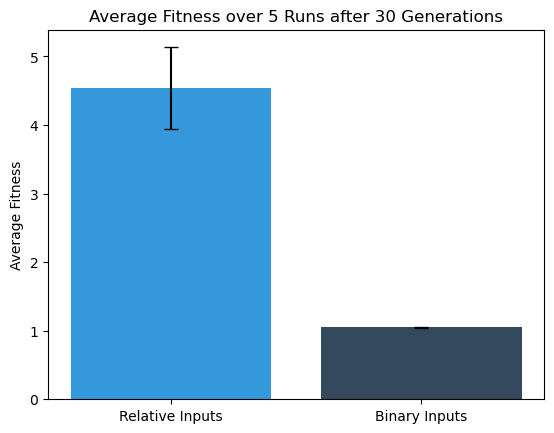

In [21]:
# Calculate average fitness and standard deviation over all runs
average_fitness_V5= np.mean([np.array(stats.get_fitness_mean())[-1] for stats in SnakeV3_stats])
std_fitness_V5 = np.std([np.array(stats.get_fitness_mean())[-1] for stats in SnakeV3_stats])

# Data to plot
fitness_means = [average_fitness_V2, average_fitness_V5]
fitness_stds = [std_fitness_V2, std_fitness_V5]
labels = ['Relative Inputs', 'Binary Inputs']

# Creating the bar plot
fig, ax = plt.subplots()
ax.bar(labels, fitness_means, yerr=fitness_stds, capsize=5, color=[ '#3498db', '#34495e'])
ax.set_ylabel('Average Fitness')
ax.set_title(f'Average Fitness over {SnakeV5.N_RUNS} Runs after {SnakeV5.N_GENERATIONS} Generations')

# Show the plot
plt.savefig(local_dir + '/' + Paths.RESULTS_PATH + '/fitness_comparison.png')
plt.show()

# Investigation 3: Obstacles
Now we've determined the right frame of reference for our inputs and outputs, we can make it a bit more challenging for the snake. You might have noticed that right now the snake adopts a very simple strategy: it always trails along the wall until it lines up with the apple, and then goes straight for it. We can make it a bit more challenging by adding obstacles to the game. To make it a fair competition, we will give the snake information on the position of this obstacle, by adding the input feature `distance_to_obstacle`.

In [22]:
SnakeV6 = SnakeGame(input_features= ['relative_wall', 'relative_body','relative_apple', 'relative_obstacle'],
                          input_frame_of_reference= 'SNAKE', 
                          output_frame_of_reference= 'SNAKE', 
                          use_obstacles= True,
                          n_runs = 5,
                          n_generations = 30,
                          time_interval= 200,
                          checkpoint_interval= 10)

#Update the NEAT configuration file with the input and output features of the SnakeV0 [This needs to be done every time the input features are changed]
print(SnakeV6.neat_params['input_output']['DefaultGenome'])
update_config('config-neat','DefaultGenome', SnakeV6.neat_params['input_output']['DefaultGenome'])

#Run the NEAT algorithm on the SnakeV1
SnakeV6_stats= SnakeV6.run_NEAT_repeated(neat_config_path)
SnakeV6_winners = [stats.best_genome() for stats in SnakeV6_stats]
best_run_idx = np.argmax([winner.fitness for winner in SnakeV6_winners])
print(f"Best run: {best_run_idx} with fitness:§ {SnakeV6_winners[best_run_idx].fitness}")

#Save results
np.save(local_dir + '/' + Paths.RESULTS_PATH + 'SnakeV6_winners', SnakeV6_winners)
np.save(local_dir + '/' + Paths.RESULTS_PATH + 'SnakeV6_stats', SnakeV6_stats)

{'num_inputs': '12', 'num_outputs': '3'}
Running NEAT algorithm, run 0
Saving checkpoint to results//checkpoints/run0/population-9
Saving checkpoint to results//checkpoints/run0/population-19
Saving checkpoint to results//checkpoints/run0/population-29
Run 0 completed, best fitness: 9.7
Running NEAT algorithm, run 1
Saving checkpoint to results//checkpoints/run1/population-9
Saving checkpoint to results//checkpoints/run1/population-19
Saving checkpoint to results//checkpoints/run1/population-29
Run 1 completed, best fitness: 11.3
Running NEAT algorithm, run 2
Saving checkpoint to results//checkpoints/run2/population-9
Saving checkpoint to results//checkpoints/run2/population-19
Saving checkpoint to results//checkpoints/run2/population-29
Run 2 completed, best fitness: 9.9
Running NEAT algorithm, run 3
Saving checkpoint to results//checkpoints/run3/population-9
Saving checkpoint to results//checkpoints/run3/population-19
Saving checkpoint to results//checkpoints/run3/population-29
Run 3

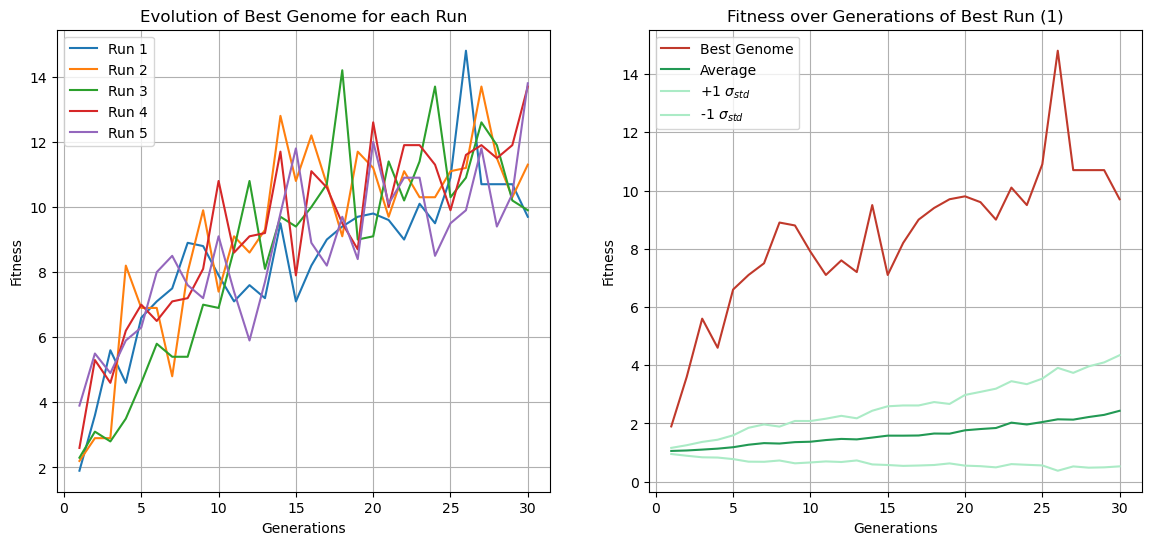

In [23]:
#Get statistics from the best run
generations = range(1, SnakeV6.N_GENERATIONS + 1)
winner_stats = SnakeV6_stats[best_run_idx]
best_fitnesses = [g.fitness for g in winner_stats.most_fit_genomes]
avg_fitnesses = np.array(winner_stats.get_fitness_mean())
stdev_fitnesses = np.array(winner_stats.get_fitness_stdev())

# Plot the best run statistics
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Get statistics from all runs
best_genomes = [[g for g in stats.most_fit_genomes] for stats in SnakeV6_stats]

# Plot the best genome of each run
for i, genome in enumerate(best_genomes):
    fitnesses = [g.fitness for g in genome]
    ax1.plot(generations, fitnesses, label=f"Run {i + 1}")

ax1.set_title("Evolution of Best Genome for each Run")
ax1.set_xlabel("Generations")
ax1.set_ylabel("Fitness")
ax1.grid()
ax1.legend(loc="best")

ax2.plot(generations, best_fitnesses, color='#c0392b', label="Best Genome")
ax2.plot(generations, avg_fitnesses, color='#229954', label="Average")
ax2.plot(generations, avg_fitnesses + stdev_fitnesses, color='#abebc6', label="+1 $\sigma_{std}$")
ax2.plot(generations, avg_fitnesses - stdev_fitnesses, color='#abebc6', label="-1 $\sigma_{std}$")

ax2.set_title(f"Fitness over Generations of Best Run ({best_run_idx + 1})")
ax2.set_xlabel("Generations")
ax2.set_ylabel("Fitness")
ax2.grid()
ax2.legend(loc="best")

plt.show()

### Check performance in a simulation

In [24]:
generation_nr_1 = 15 
generation_nr_2 = -1 # -1 is the last generation

# Get the best genome at every generation
best_genomes = [g for g in SnakeV6_stats[best_run_idx].most_fit_genomes]

genome_1 = best_genomes[generation_nr_1]
genome_2 = best_genomes[generation_nr_2]

#uncomment one to test either genome_1 or genome_2
# SnakeV6.test_winner(genome_1, neat_config_path)
# SnakeV6.test_winner(genome_2, neat_config_path)

# Investigation 4: Memory


In [25]:
SnakeV7 = SnakeGame(input_features= ['relative_wall', 'relative_body','relative_apple', 'history'],
                          input_frame_of_reference= 'SNAKE', 
                          output_frame_of_reference= 'SNAKE',
                          history_length = 5,
                          use_obstacles= False,
                          n_runs = 5,
                          n_generations = 30,
                          time_interval= 200,
                          checkpoint_interval= 10)

#Update the NEAT configuration file with the input and output features of the SnakeV0 [This needs to be done every time the input features are changed]
print(SnakeV7.neat_params['input_output']['DefaultGenome'])
update_config('config-neat','DefaultGenome', SnakeV7.neat_params['input_output']['DefaultGenome'])

#Run the NEAT algorithm on the SnakeV0
SnakeV7_stats = SnakeV7.run_NEAT_repeated(neat_config_path)

#Save results
np.save(local_dir + '/' + Paths.RESULTS_PATH + 'SnakeV7_stats', SnakeV7_stats)

# Get the best genome of all generations for all runs
Baseline_winners = [stats.best_genome() for stats in SnakeV7_stats]

# Get the best genome of all generations over all runs
best_run_idx = np.argmax([winner.fitness for winner in Baseline_winners])
print(f"Best run: {best_run_idx} with fitness:§ {Baseline_winners[best_run_idx].fitness}")

{'num_inputs': '14', 'num_outputs': '3'}
Running NEAT algorithm, run 0
Saving checkpoint to results//checkpoints/run0/population-9
Saving checkpoint to results//checkpoints/run0/population-19
Saving checkpoint to results//checkpoints/run0/population-29
Run 0 completed, best fitness: 26.8
Running NEAT algorithm, run 1
Saving checkpoint to results//checkpoints/run1/population-9
Saving checkpoint to results//checkpoints/run1/population-19
Saving checkpoint to results//checkpoints/run1/population-29
Run 1 completed, best fitness: 25.3
Running NEAT algorithm, run 2
Saving checkpoint to results//checkpoints/run2/population-9
Saving checkpoint to results//checkpoints/run2/population-19
Saving checkpoint to results//checkpoints/run2/population-29
Run 2 completed, best fitness: 26.9
Running NEAT algorithm, run 3
Saving checkpoint to results//checkpoints/run3/population-9
Saving checkpoint to results//checkpoints/run3/population-19


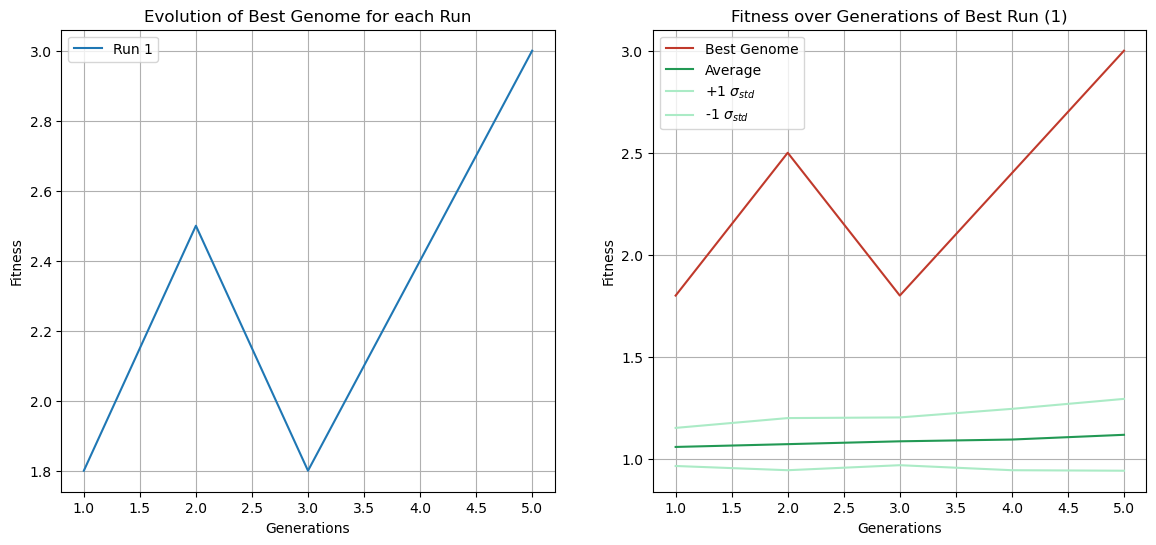

In [ ]:
#Get statistics from the best run
generations = range(1, SnakeV7.N_GENERATIONS + 1)
winner_stats = SnakeV7_stats[best_run_idx]
best_fitnesses = [g.fitness for g in winner_stats.most_fit_genomes]
avg_fitnesses = np.array(winner_stats.get_fitness_mean())
stdev_fitnesses = np.array(winner_stats.get_fitness_stdev())

# Plot the best run statistics
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Get statistics from all runs
best_genomes = [[g for g in stats.most_fit_genomes] for stats in SnakeV7_stats]

# Plot the best genome of each run
for i, genome in enumerate(best_genomes):
    fitnesses = [g.fitness for g in genome]
    ax1.plot(generations, fitnesses, label=f"Run {i + 1}")

ax1.set_title("Evolution of Best Genome for each Run")
ax1.set_xlabel("Generations")
ax1.set_ylabel("Fitness")
ax1.grid()
ax1.legend(loc="best")

ax2.plot(generations, best_fitnesses, color='#c0392b', label="Best Genome")
ax2.plot(generations, avg_fitnesses, color='#229954', label="Average")
ax2.plot(generations, avg_fitnesses + stdev_fitnesses, color='#abebc6', label="+1 $\sigma_{std}$")
ax2.plot(generations, avg_fitnesses - stdev_fitnesses, color='#abebc6', label="-1 $\sigma_{std}$")

ax2.set_title(f"Fitness over Generations of Best Run ({best_run_idx + 1})")
ax2.set_xlabel("Generations")
ax2.set_ylabel("Fitness")
ax2.grid()
ax2.legend(loc="best")


plt.show()

In [ ]:
generation_nr_1 = 15 
generation_nr_2 = -1 # -1 is the last generation

# Get the best genome at every generation
best_genomes = [g for g in SnakeV7_stats[best_run_idx].most_fit_genomes]

# genome_1 = best_genomes[generation_nr_1]
genome_2 = best_genomes[generation_nr_2]

#uncomment one to test either genome_1 or genome_2
# SnakeV7.test_winner(genome_1, neat_config_path)
# SnakeV7.test_winner(genome_2, neat_config_path)

SystemExit: 

/Users/ringo/anaconda3/envs/BrainyBoa/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


# ---------WASTELAND ; DO NOT CHECK BELOW THIS LINE----------

### Checkpoint restoration [DOES NOT WORK PROPERLY FOR NOW]

If I restore a checkpoint, and then check the fitness of that population, it does not match up with the graphs above. I am not sure why. I will try to figure it out later, if we will actually need to use this.

In [ ]:
generation_nr_1 = 18
population_1 = neat.Checkpointer.restore_checkpoint(f'results/checkpoints/run{best_run_idx}/population-{generation_nr_1}')

genome_tuples = list(iter(population_1.population.items()))   # List of (genome_id, genome) tuples.

# Assign a fitness value to each genome
SnakeV0.eval_genomes(genome_tuples, neat_config)

# Get the best genome of the generation
genomes = population_1.population.values() # List of the genomes after evaluation.
best_genome = None
for i, g in enumerate(iter(genomes)):
    if best_genome is None or g.fitness > best_genome.fitness:
        best_genome = g

print(f"Best genome has fitness: {best_genome.fitness}")

In [ ]:
# Load the data
# SnakeV0_winners = np.load(local_dir + '/results/SnakeV0_winners.npy', allow_pickle=True)
# SnakeV0_stats = np.load(local_dir + '/results/SnakeV0_winners.npy', allow_pickle=True)

# SnakeV1_winners = np.load(local_dir + '/results/SnakeV1_winners.npy', allow_pickle=True)
# SnakeV1_stats = np.load(local_dir + '/results/SnakeV1_stats.npy', allow_pickle=True)

In [ ]:
# Calculate average fitness and standard deviation for winners
average_fitness_winners = np.mean([winner.fitness for winner in Baseline_winners])
std_fitness_winners = np.std([winner.fitness for winner in Baseline_winners])

# Calculate average fitness and standard deviation over all runs
average_fitness = np.mean([np.array(stats.get_fitness_mean())[-1] for stats in SnakeV0_stats])
std_fitness = np.std([np.array(stats.get_fitness_mean())[-1] for stats in SnakeV0_stats])

# Data to plot
fitness_means = [average_fitness_winners, average_fitness]
fitness_stds = [std_fitness_winners, std_fitness]
labels = ['Best Genomes', 'All Genomes']

# Creating the bar plot
fig, ax = plt.subplots()
ax.bar(labels, fitness_means, yerr=fitness_stds, capsize=5, color=['#c0392b', '#229954'])
ax.set_ylabel('Average Fitness')
ax.set_title(f'Average Fitness over {SnakeV0.N_RUNS} Runs')

# Show the plot
plt.savefig(local_dir + '/' + Paths.RESULTS_PATH + '/fitness_comparison.png')
plt.show()